# Jupyter notebook to visualize our results after training PyTorch model

Please run this notebook from the notebooks directory.

Some useful links:
- https://brandonrozek.com/blog/jupyterwithpyenv/

- https://github.com/microsoft/vscode-jupyter/wiki/Setting-Up-Run-by-Line-and-Debugging-for-Notebooks

In [9]:
!python --version

Python 3.10.6


In [10]:
import sys

sys.path.append('../')
sys.path.append('../src')

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from hydra import initialize, compose
from omegaconf import OmegaConf, DictConfig
from pathlib import Path
from src import *
from src.trainer import Trainer


with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name='trainer.yaml')

    cfg.wandb.mode = "disabled"
    ## Save dataset or load it
    # cfg.dataset.save_format = "pkl"  # to save dataset
    p = Path(cfg.dataset.filename)
    cfg.dataset.filename = f"../{str(p.parent)}/{p.stem}_dataset.pkl"
    # Comment the previous lines if don't want to save dataset or load it

    trainer = Trainer(cfg)

    ### Loading checkpoint
    general_checkpoint = torch.load("../checkpoints/last_general_checkpoint.pth")
    trainer.model.load_state_dict(general_checkpoint["model_state_dict"])
    trainer.optimizer.load_state_dict(general_checkpoint["optimizer_state_dict"])

    trainer.epoch = general_checkpoint["epoch"]
    torch.train_loss = general_checkpoint["train_loss"]
    torch.val_loss = general_checkpoint["val_loss"]
    
    trainer.model.eval()
    
    print(OmegaConf.to_yaml(cfg))


Config:
wandb:
  project: POLAR-background-prediction
  mode: disabled
wandb_watch: true
common:
  seed: 42
  n_epochs: 200
  device: cuda
dataset:
  filename: ../data/nf1rate_dataset.pkl
  save_format: null
  new_columns:
  - rate[0]/rate_err[0]
  feature_names:
  - unix_time
  - glat
  - glon
  - altitude
  - temperature
  - fe_cosmic
  - raz
  - decz
  - rax
  - decx
  - is_orbit_up
  - time_since_saa
  - B_r
  - B_theta
  - B_phi
  target_names:
  - rate[0]/rate_err[0]
  train:
    size: 0.6
    batch_size: 200
    shuffle: true
  val:
    size: 0.2
    batch_size: 200
  test:
    size: 0.2
    batch_size: 200
model:
  type: MLP
  inner_activation_fct: ReLU
  output_activation_fct: null
  hidden_layer_sizes:
  - 100
  - 100
optimizer:
  hyperparams:
    lr: 0.001
    betas:
    - 0.9
    - 0.999
    eps: 1.0e-08

Using device: cuda


Using default identity activationfunction for last layer
wandb:
  project: POLAR-background-prediction
  mode: disabled
wandb_watch: true
common:
  seed: 42
  n_epochs: 200
  device: cuda
dataset:
  filename: ../data/nf1rate_dataset.pkl
  save_format: null
  new_columns:
  - rate[0]/rate_err[0]
  feature_names:
  - unix_time
  - glat
  - glon
  - altitude
  - temperature
  - fe_cosmic
  - raz
  - decz
  - rax
  - decx
  - is_orbit_up
  - time_since_saa
  - B_r
  - B_theta
  - B_phi
  target_names:
  - rate[0]/rate_err[0]
  train:
    size: 0.6
    batch_size: 200
    shuffle: true
  val:
    size: 0.2
    batch_size: 200
  test:
    size: 0.2
    batch_size: 200
model:
  type: MLP
  inner_activation_fct: ReLU
  output_activation_fct: null
  hidden_layer_sizes:
  - 100
  - 100
optimizer:
  hyperparams:
    lr: 0.001
    betas:
    - 0.9
    - 0.999
    eps: 1.0e-08



In [12]:
trainer.dataset_full.data_df

,unix_time,glat,glon,altitude,temperature,fe_cosmic,corrected,correrr,config,raz,...,rate_err[4],rate_err[5],rate_err[6],rate_err[7],rate_err[8],rate_err[9],rate_err[10],rate_err[11],rate_err[12],rate[0]/rate_err[0]
0,1.483525e+09,41.273513,64.930544,376.565432,33.500000,1177.0,1111.225454,0.0,42,335.977594,...,2.567960,57.652239,52.385469,39.950259,26.693248,22.110430,62.045995,12.909292,60.913647,28.621580
1,1.483525e+09,41.301336,65.091966,376.553905,33.500000,1185.0,1077.260702,0.0,42,336.125659,...,1.097337,58.313242,53.576569,42.127169,27.986472,22.971606,62.461609,13.256035,62.418086,27.929632
2,1.483525e+09,41.301336,65.091966,376.553905,33.500000,1185.0,1067.501924,0.0,42,336.125659,...,2.536110,58.309515,53.611688,41.436761,27.814336,23.010703,62.985185,13.034515,62.923828,27.636904
3,1.483525e+09,41.328899,65.253475,376.536191,33.500000,2154.0,1108.812904,0.0,42,336.273850,...,2.284171,58.768888,53.985650,41.722093,27.564099,22.368073,63.693900,12.626513,63.606376,28.166676
4,1.483525e+09,41.328899,65.253475,376.536191,33.500000,2154.0,1110.524550,0.0,42,336.273850,...,1.408732,58.254816,53.523039,41.459358,28.045588,23.051952,63.082339,14.103237,63.008902,28.515913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956641,1.489745e+09,-42.757777,126.189354,386.590141,34.400002,24460.0,1946.386405,0.0,42,91.466481,...,3.133076,78.836820,71.228548,55.682940,38.233360,31.472766,86.974534,18.192699,86.974534,39.073977
3956642,1.489745e+09,-42.758912,126.358379,386.578593,34.400002,24778.0,2020.254206,0.0,42,91.614903,...,4.632954,79.408475,72.413146,56.606334,38.744268,32.452418,87.649576,18.919566,87.649576,40.109691
3956643,1.489745e+09,-42.758912,126.358379,386.578593,34.400002,24778.0,1960.692600,0.0,42,91.614903,...,3.101901,78.254113,71.264054,55.356600,37.391817,30.278941,86.726588,17.912328,86.721439,39.401131
3956644,1.489745e+09,-42.759779,126.527354,386.562382,34.400002,24223.0,2001.103329,0.0,42,91.763169,...,3.469219,77.563992,70.275058,55.193748,38.037999,31.583499,86.736518,17.897704,86.723956,39.691491


In [47]:

## Prediction on validation set (e.g rate[0])
# Need to transform before inputting the whole validation set into
# the model
dataset_full = trainer.dataset_full
dataset_val_tensor = trainer.dataset_val.dataset.X[trainer.dataset_val.indices]
dataset_val_tensor = dataset_full.transform(dataset_val_tensor)

pred = trainer.model(dataset_val_tensor)

data_df = dataset_full.data_df
x_val_df = data_df.iloc[trainer.dataset_val.indices, :]

Index(['unix_time', 'glat', 'glon', 'altitude', 'temperature', 'fe_cosmic',
       'raz', 'decz', 'rax', 'decx', 'is_orbit_up', 'time_since_saa', 'B_r',
       'B_theta', 'B_phi'],
      dtype='object')


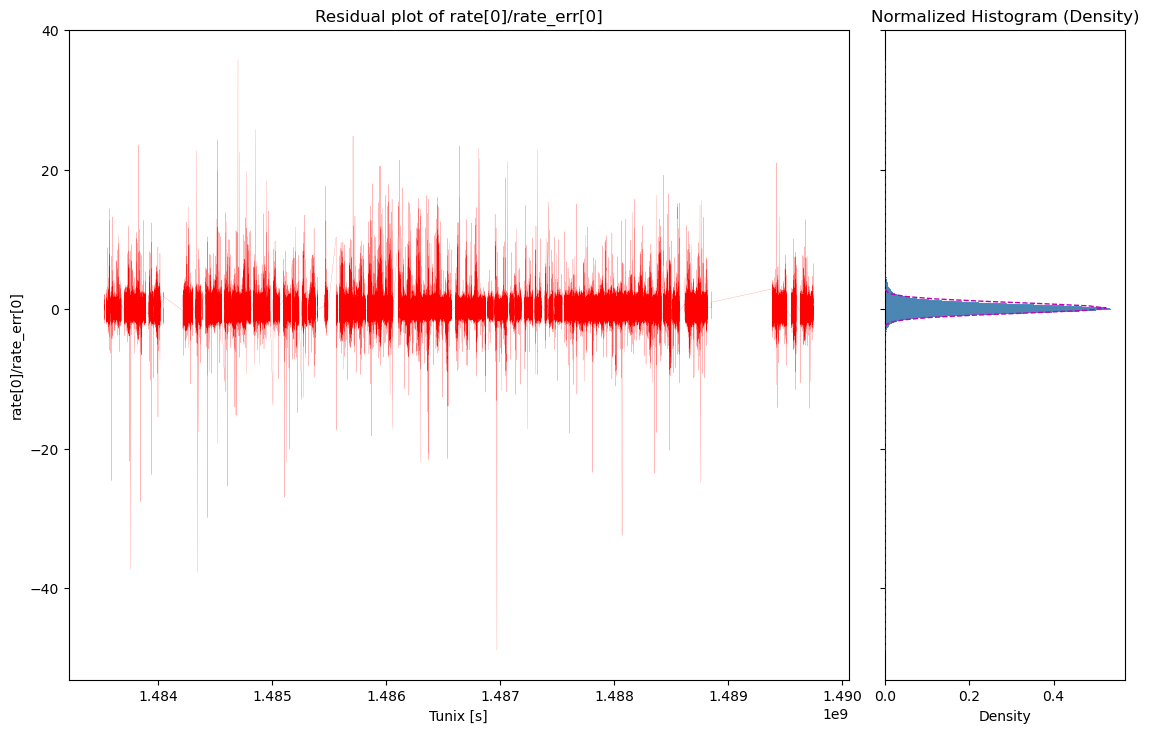

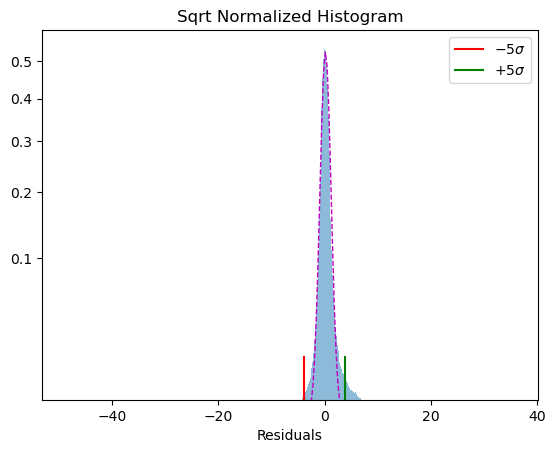

In [48]:
from src.visualizer import plot_val_residual

for target_name in cfg.dataset.target_names:
    plot_val_residual(trainer.dataset_val,
                                pred,
                                target_name=target_name,
                                save_path=None,
                                save_path_hist=None)

In [49]:
from src.visualizer import get_time_y_y_hat, find_moments
tmp = get_time_y_y_hat(trainer.dataset_val, pred, target_name)
sorted_time_val, sorted_y_val, sorted_y_hat_val = tmp
del tmp

residuals = sorted_y_val-sorted_y_hat_val
new_mean, new_std = find_moments(residuals)

Index(['unix_time', 'glat', 'glon', 'altitude', 'temperature', 'fe_cosmic',
       'raz', 'decz', 'rax', 'decx', 'is_orbit_up', 'time_since_saa', 'B_r',
       'B_theta', 'B_phi'],
      dtype='object')


In [64]:
np.sum(residuals.values > 5*new_std)

9980

/home/zenchiyu/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


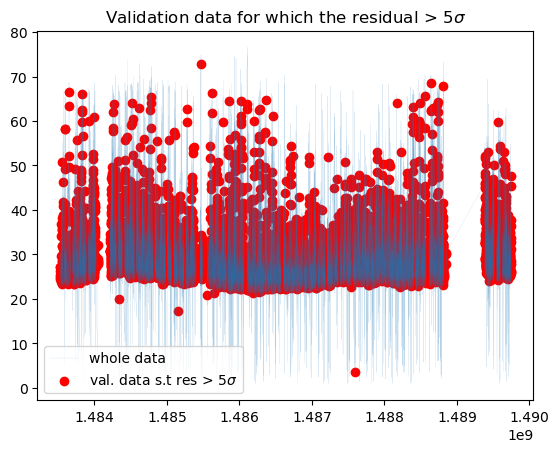

In [68]:
plt.plot(data_df["unix_time"], data_df["rate[0]/rate_err[0]"],
         linewidth=0.05, label="whole data")

plt.scatter(x_val_df.loc[residuals.values > 5*new_std, "unix_time"],
         x_val_df.loc[residuals.values > 5*new_std, "rate[0]/rate_err[0]"],
         color='r', label=r"val. data s.t res > $5\sigma$")
plt.title(r"Validation data for which the residual > $5\sigma$")
plt.legend()
plt.show()

### GRBs

In [15]:
import pandas as pd

In [16]:
GRBs = pd.read_csv("../data/GRBs.csv")
GRBs

,Number,GRB_Name,Trigger_time_UTC,unix_time
0,1,GRB_160924A,2016-09-24T06:04:09.040,1.474697e+09
1,2,GRB_160928A,2016-09-28T19:48:05.000,1.475092e+09
2,3,GRB_161009651,2016-10-09T15:38:07.190,1.476027e+09
3,4,GRB_161011217,2016-10-11T05:13:44.420,1.476163e+09
4,5,GRB_161012989,2016-10-12T23:45:11.380,1.476316e+09
5,6,GRB_161013948,2016-10-13T22:44:40.100,1.476399e+09
6,7,GRB_161120401,2016-11-20T09:38:33.520,1.479635e+09
7,8,GRB_161129A,2016-11-29T07:11:40.000,1.480404e+09
8,9,GRB_161203A,2016-12-03T18:41:07.750,1.480790e+09
9,10,GRB_161205A,2016-12-05T13:27:18.000,1.480944e+09


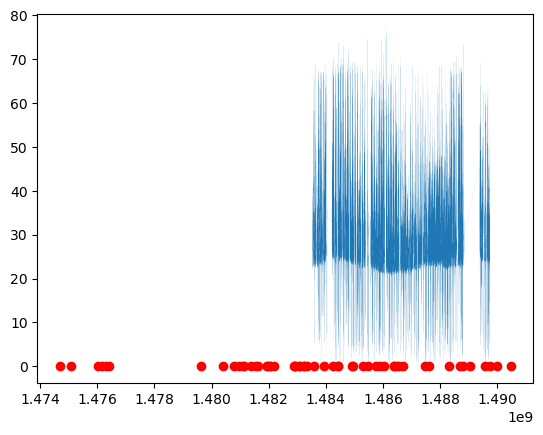

In [25]:
plt.plot(data_df["unix_time"], data_df["rate[0]/rate_err[0]"], linewidth=0.05)
plt.scatter(GRBs["unix_time"], np.zeros_like(GRBs["unix_time"]), color="r")
plt.title("55 GRBs against full dataset")

Let's only take a look at the GRBs happening within the same time range

In [79]:
mask = data_df["unix_time"].min() <= GRBs["unix_time"].values
mask &= GRBs["unix_time"].values <= data_df["unix_time"].max()
print(f"Out of 55, there are: {mask.sum()} GRBs within our time range")

Out of 55, there are: 25 GRBs within our time range


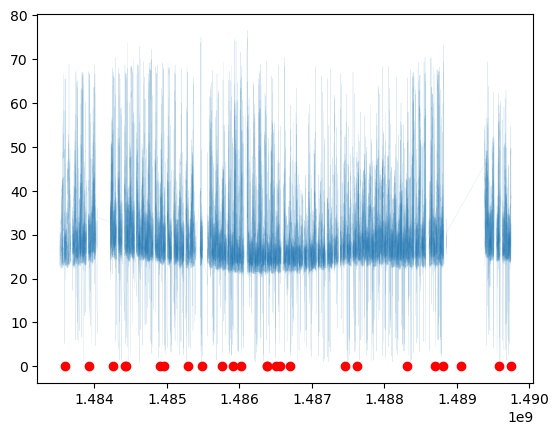

In [80]:
plt.plot(data_df["unix_time"], data_df["rate[0]/rate_err[0]"], linewidth=0.05)
plt.scatter(GRBs["unix_time"][mask], np.zeros_like(GRBs["unix_time"][mask]), color="r")
plt.show()

Zooming into the GRBs with a window of 50 seconds before and 50 seconds after

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


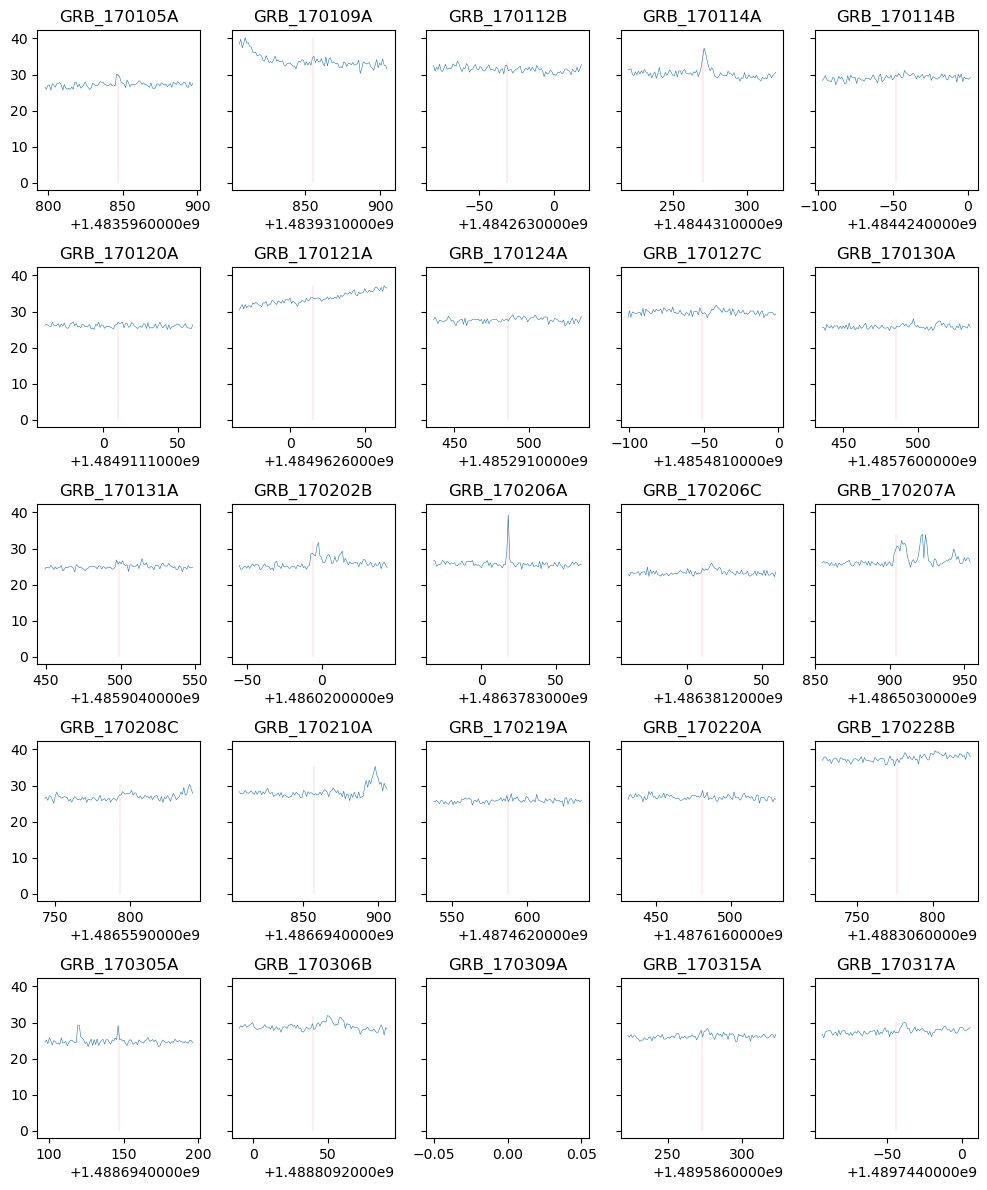

In [113]:
fig, axs = plt.subplots(5, 5, figsize=(10, 12), sharey=True)

for i, GRB_name, GRB_tunix in zip(range(mask.sum()),
                        GRBs["GRB_Name"][mask],
                        GRBs["unix_time"][mask]):
    m = data_df["unix_time"] >= GRB_tunix-50
    m &= data_df["unix_time"] <= GRB_tunix+50
    axs[i//5, i%5].plot(data_df[m]["unix_time"],
             data_df[m]["rate[0]/rate_err[0]"], linewidth=0.4)
    axs[i//5, i%5].vlines(GRB_tunix, 0,
                          data_df[m]["rate[0]/rate_err[0]"].max(),
                          'r', linewidth=0.1)
    axs[i//5, i%5].set_title(GRB_name)
plt.tight_layout()

Comparing with where our algo fails

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


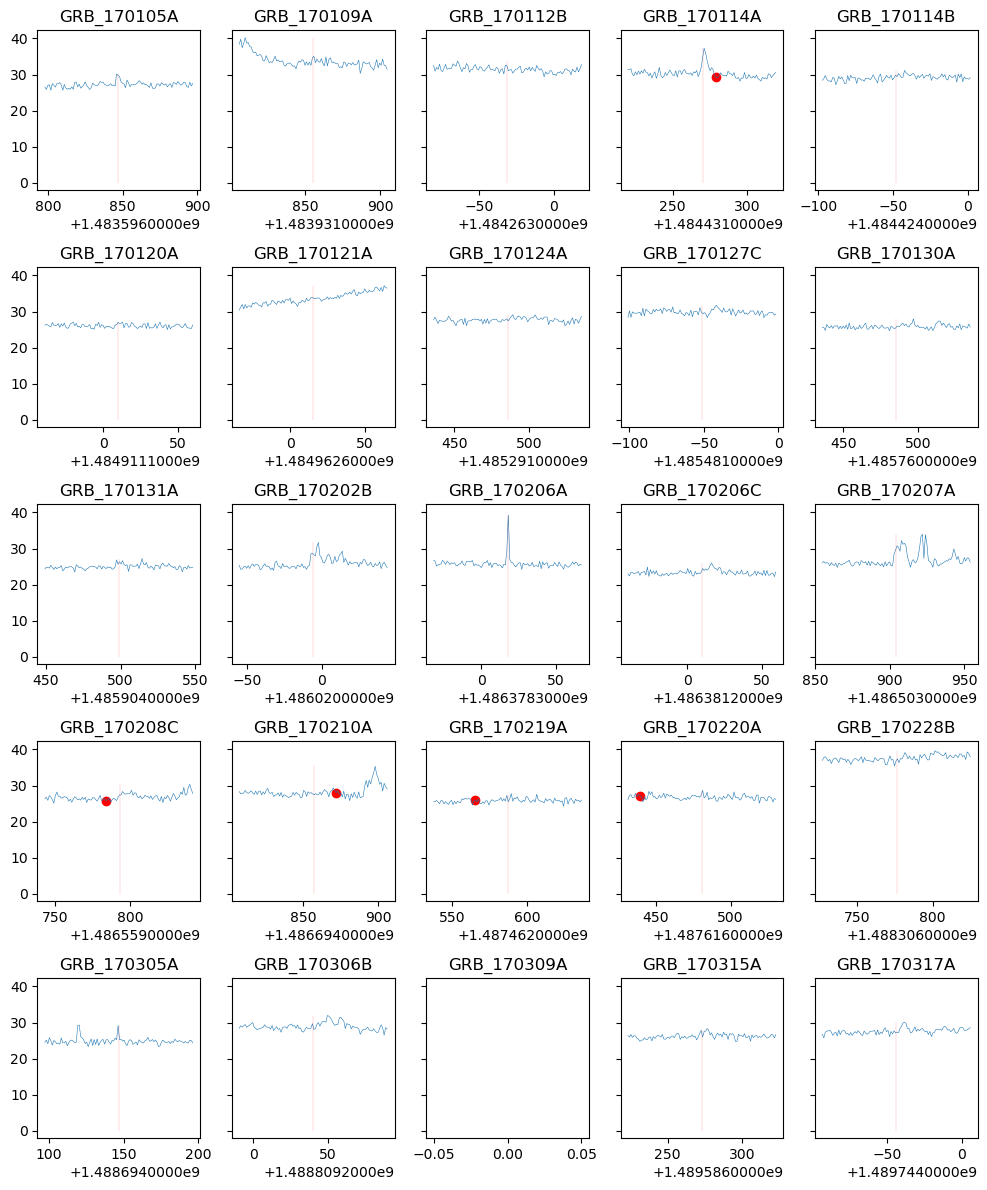

In [114]:
fig, axs = plt.subplots(5, 5, figsize=(10, 12), sharey=True)

for i, GRB_name, GRB_tunix in zip(range(mask.sum()),
                        GRBs["GRB_Name"][mask],
                        GRBs["unix_time"][mask]):
    m = data_df["unix_time"] >= GRB_tunix-50
    m &= data_df["unix_time"] <= GRB_tunix+50
    mval = x_val_df["unix_time"] >= GRB_tunix-50
    mval &= x_val_df["unix_time"] <= GRB_tunix+50
    mval &= (residuals.values > 5*new_std)

    axs[i//5, i%5].plot(data_df[m]["unix_time"],
             data_df[m]["rate[0]/rate_err[0]"], linewidth=0.4)
    axs[i//5, i%5].vlines(GRB_tunix, 0,
                          data_df[m]["rate[0]/rate_err[0]"].max(),
                          'r', linewidth=0.1)
    axs[i//5, i%5].set_title(GRB_name)

    # Based on our residuals
    axs[i//5, i%5].scatter(x_val_df.loc[mval, "unix_time"],
         x_val_df.loc[mval, "rate[0]/rate_err[0]"],
         color='r', label=r"val. data s.t res > $5\sigma$")
plt.tight_layout()